In [1]:
! yes | pip3 uninstall opencv-python
! yes | pip3 uninstall opencv-contrib-python
! yes | pip3 install opencv-python==3.4.2.17
! yes | pip3 install opencv-contrib-python==3.4.2.17

Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Gui-48e93776.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5XcbQpa-c112ba75.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/d

In [2]:
import os
import cv2

import numpy as np

from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.vq import vq
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
train_path="/content/drive/MyDrive/Colab Notebooks/Computer Vision/101_ObjectCategories"
class_names=os.listdir(train_path)
print(class_names)

['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head', 'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']


**Find training images path and Read train images, and compute SIFT descriptors.**

In [34]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/101_ObjectCategories/"
label = 0
train_des_sift = list()
test_des_sift = list()
train_des_surf = list()
test_des_surf = list()
train_labels = list()
test_labels = list()
sift=cv2.xfeatures2d.SIFT_create()
surf=cv2.xfeatures2d.SURF_create()

for cls in tqdm(os.listdir(DATA_ROOT)):
  img_list = os.listdir(DATA_ROOT+'/'+cls)
  img_list.sort()

  for img in img_list[:30]:
    image = cv2.imread(DATA_ROOT+'/'+cls+'/'+img)
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)   
    
    step_size = 10
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) for x in range(0, gray.shape[1], step_size)]
    keypoint, des = sift.compute(gray, kp)
    train_des_sift.append(des)
    kp, des = surf.detectAndCompute(gray,None)
    
    train_des_surf.append(des)
    train_labels.append(label)

  limit_cnt = 0

  for img in img_list[30:]:
    if limit_cnt == 50 :
      break
    image = cv2.imread(DATA_ROOT+'/'+cls+'/'+img)
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    step_size = 10
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) for x in range(0, gray.shape[1], step_size)]
    keypoint, des = sift.compute(gray, kp)
    test_des_sift.append(des)
    kp, des = surf.detectAndCompute(gray,None)
    test_des_surf.append(des)
    test_labels.append(label)
    limit_cnt = limit_cnt +1

  label = label + 1

100%|██████████| 21/21 [04:18<00:00, 12.30s/it]


In [35]:
train_des_sift[1]

array([[  0.,   0.,   0., ..., 131., 131.,  33.],
       [  0.,   0.,   0., ..., 127., 107.,  70.],
       [  0.,   0.,   0., ...,  13., 125.,  89.],
       ...,
       [ 87.,  28.,   6., ...,   0.,   0.,   0.],
       [ 75.,  10.,   9., ...,   0.,   0.,   0.],
       [ 26.,   5.,  16., ...,   0.,   0.,   0.]], dtype=float32)

**Dictionary/Vocabulary construction**

In [36]:
def Kmeans(k,train_des):
  train_des_arr = np.array(train_des[0])
  for remaining in tqdm(train_des[1:]):
    train_des_arr = np.vstack((train_des_arr, remaining))
  kmeans = MiniBatchKMeans(n_clusters = k, init='k-means++',
                          n_init=10).fit(train_des_arr)
  return kmeans
kmeans_sift=Kmeans(500,train_des_sift)
kmeans_suft=Kmeans(500,train_des_surf)


100%|██████████| 629/629 [00:08<00:00, 76.29it/s]


**Vector quantization**

In [37]:
histogram_train_sift = list()
histogram_test_sift = list()
histogram_train_surf = list()
histogram_test_surf = list()
def getHistograms(descriptors, kmeans,des_H):
  for i in range(len(des_H)) :
    Histogram = vq(des_H[i],kmeans.cluster_centers_)
    Feature = np.histogram(Histogram[0],bins=list(range(201)))
    descriptors.append(Feature[0])
  return np.array(descriptors)
histogram_train_sift=getHistograms(histogram_train_sift,kmeans_sift,train_des_sift)
histogram_test_sift=getHistograms(histogram_test_sift,kmeans_sift,test_des_sift)
histogram_train_surf=getHistograms(histogram_train_surf,kmeans_suft,train_des_surf)
histogram_test_surf=getHistograms(histogram_test_surf,kmeans_suft,test_des_surf)


In [38]:
histogram_train_sift

array([[0, 0, 2, ..., 0, 0, 8],
       [4, 0, 0, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 3],
       [3, 1, 1, ..., 0, 2, 6],
       [0, 0, 3, ..., 0, 0, 0]])

**Calculate term Frequency-Inverse Document Frequency(TF-IDF)**

In [39]:
def reweight_tf_idf(histograms):
    re_hists  = np.zeros(histograms.shape)
    N = histograms.shape[0]
    n_i = np.sum(histograms > 0, axis=0)
    for hist_id in range(histograms.shape[0]):
        n_d  = np.sum(histograms[hist_id])
        for bin_id in range(len(histograms[hist_id])): 
            re_hists[hist_id, bin_id] = histograms[hist_id, bin_id]/ n_d * np.log(N/n_i[bin_id])
#             print(re_hists[hist_id, bin_id], histograms[hist_id, bin_id], n_d, N, n_i[bin_id])
    return re_hists

histogram_train_sift_TF = reweight_tf_idf(histogram_train_sift)
histogram_test_sift_TF = reweight_tf_idf(histogram_test_sift)

histogram_train_surf_TF = reweight_tf_idf(histogram_train_surf)
histogram_test_surf_TF = reweight_tf_idf(histogram_test_surf)


In [40]:
histogram_train_sift_TF

array([[0.        , 0.        , 0.00700204, ..., 0.        , 0.        ,
        0.02306801],
       [0.01451332, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00773992],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00711574],
       [0.01107936, 0.00707076, 0.00318843, ..., 0.        , 0.00961324,
        0.01575627],
       [0.        , 0.        , 0.00917219, ..., 0.        , 0.        ,
        0.        ]])

**Learned Classifier**

In [41]:
svm_model_sift = svm.SVC(gamma='scale')
svm_model_sift.fit(histogram_train_sift_TF, train_labels)


SVC()

In [42]:
y_predict_sift_svm = svm_model_sift.predict(histogram_test_sift_TF)

print(classification_report(test_labels, y_predict_sift_svm, target_names=['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head', 'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']))

                precision    recall  f1-score   support

  brontosaurus       0.40      0.31      0.35        13
         brain       0.87      0.40      0.55        50
        buddha       0.59      0.26      0.36        50
     accordion       0.92      0.92      0.92        25
        camera       0.40      0.70      0.51        20
     butterfly       0.46      0.52      0.49        50
     airplanes       0.91      0.80      0.85        50
      car_side       0.93      0.78      0.85        50
          crab       0.23      0.47      0.31        43
     crocodile       0.75      0.15      0.25        20
crocodile_head       0.17      0.48      0.25        21
      crayfish       0.43      0.15      0.22        40
     dalmatian       0.69      0.65      0.67        37
           cup       0.33      0.37      0.35        27
    strawberry       0.12      0.60      0.21         5
        pigeon       0.33      0.20      0.25        15
      yin_yang       0.88      0.70      0.78  

In [43]:
knn_SIFT = KNeighborsClassifier(n_neighbors=1)
knn_SIFT.fit(histogram_train_sift_TF, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [44]:
y_predict_sift_knn = knn_SIFT.predict(histogram_test_sift_TF)

print(classification_report(test_labels, y_predict_sift_knn,target_names=['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head',
                                                                          'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']))

                precision    recall  f1-score   support

  brontosaurus       0.09      0.15      0.11        13
         brain       0.58      0.44      0.50        50
        buddha       0.35      0.22      0.27        50
     accordion       0.94      0.68      0.79        25
        camera       0.27      0.60      0.37        20
     butterfly       0.34      0.22      0.27        50
     airplanes       0.86      0.62      0.72        50
      car_side       0.78      0.78      0.78        50
          crab       0.15      0.19      0.17        43
     crocodile       0.17      0.15      0.16        20
crocodile_head       0.15      0.29      0.20        21
      crayfish       0.38      0.12      0.19        40
     dalmatian       0.44      0.32      0.38        37
           cup       0.23      0.19      0.20        27
    strawberry       0.21      0.60      0.32         5
        pigeon       0.13      0.27      0.17        15
      yin_yang       0.77      0.77      0.77  

In [45]:
svm_model_suft = svm.SVC(gamma='scale')
svm_model_suft.fit(histogram_train_surf_TF, train_labels)

SVC()

In [46]:
y_predict_surf_svm = svm_model_suft.predict(histogram_test_surf_TF)

print(classification_report(test_labels, y_predict_surf_svm,target_names=['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head',
                                                                          'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']))


                precision    recall  f1-score   support

  brontosaurus       0.15      0.15      0.15        13
         brain       0.73      0.44      0.55        50
        buddha       0.34      0.38      0.36        50
     accordion       0.73      0.44      0.55        25
        camera       0.24      0.45      0.32        20
     butterfly       0.21      0.08      0.12        50
     airplanes       0.74      0.56      0.64        50
      car_side       0.76      0.58      0.66        50
          crab       0.20      0.28      0.24        43
     crocodile       0.30      0.30      0.30        20
crocodile_head       0.14      0.62      0.23        21
      crayfish       0.33      0.05      0.09        40
     dalmatian       0.57      0.65      0.61        37
           cup       0.08      0.07      0.08        27
    strawberry       0.30      0.60      0.40         5
        pigeon       0.29      0.13      0.18        15
      yin_yang       0.61      0.67      0.63  

In [47]:
knn_SURF = KNeighborsClassifier(n_neighbors=1)
knn_SURF.fit(histogram_train_surf_TF, train_labels)

KNeighborsClassifier(n_neighbors=1)

In [48]:
y_predict_surf_knn = knn_SURF.predict(histogram_test_surf_TF)

print(classification_report(test_labels, y_predict_surf_knn,target_names=['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head',
                                                                          'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']))

                precision    recall  f1-score   support

  brontosaurus       0.07      0.23      0.11        13
         brain       0.52      0.30      0.38        50
        buddha       0.22      0.22      0.22        50
     accordion       0.73      0.44      0.55        25
        camera       0.15      0.35      0.21        20
     butterfly       0.29      0.12      0.17        50
     airplanes       0.54      0.28      0.37        50
      car_side       0.83      0.10      0.18        50
          crab       0.13      0.26      0.17        43
     crocodile       0.17      0.20      0.19        20
crocodile_head       0.08      0.19      0.11        21
      crayfish       0.07      0.05      0.06        40
     dalmatian       0.25      0.46      0.33        37
           cup       0.06      0.04      0.04        27
    strawberry       0.19      0.60      0.29         5
        pigeon       0.13      0.27      0.17        15
      yin_yang       0.78      0.47      0.58  

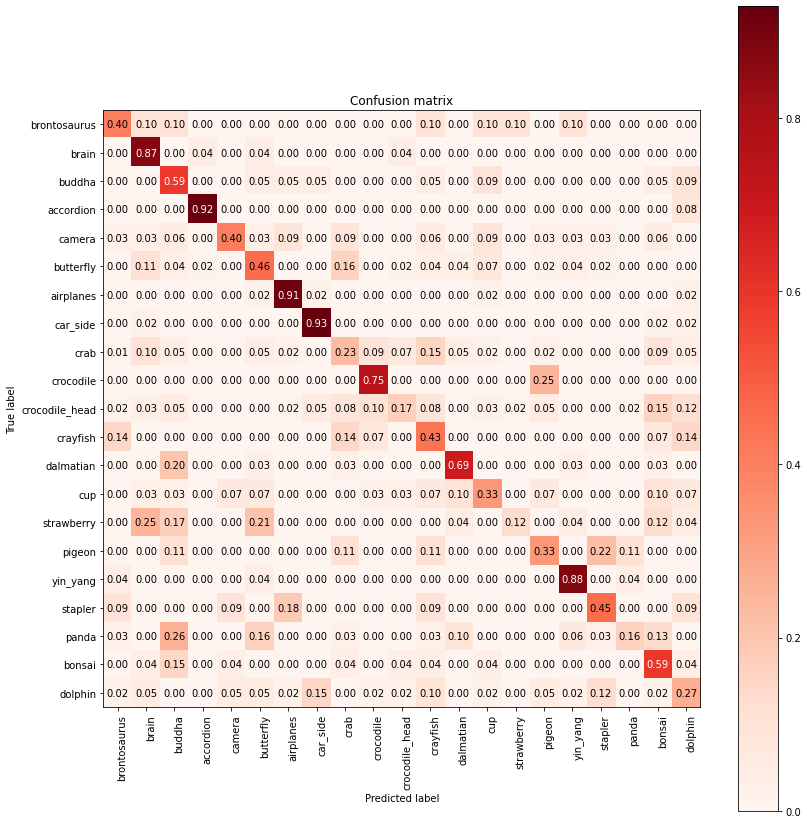

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Reds):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax
c_names=['brontosaurus', 'brain', 'buddha', 'accordion', 'camera', 'butterfly', 'airplanes', 'car_side', 'crab', 'crocodile', 'crocodile_head',
                                                                          'crayfish', 'dalmatian', 'cup', 'strawberry', 'pigeon', 'yin_yang', 'stapler', 'panda', 'bonsai', 'dolphin']
cm2 = confusion_matrix(y_predict_sift_svm, test_labels)
fig=plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()